# Keras for Text Classification

**Learning Objectives**
* Learn how to tokenize and integerize a corpus of text for training in Keras
* Learn about one-hot-encodings and the embedding to represent words in Keras
* Learn about the bag-of-word representation for sentences
* Learn how to use DNN/CNN/RNN model to classify text in keras

## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in the previous lab.

In a first step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.


In [1]:
# Ensure that we have the right version of Tensorflow installed.
!pip freeze | grep tf-nightly-2.0-preview || pip install tf-nightly-2.0-preview

tf-nightly-2.0-preview==2.0.0.dev20190917


In [2]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

/Users/dherin/Desktop/asl/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dherin/Desktop/asl/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dherin/Desktop/asl/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dherin/Desktop/asl/venv/lib/python3.6/site-packages

2.0.0-beta1


/Users/dherin/Desktop/asl/venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dherin/Desktop/asl/venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dherin/Desktop/asl/venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dherin/Desktop/asl/venv/lib/py

In [3]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [4]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [5]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,show hn tubemaps tube routes from terminal ...,github
1,data-crunching is coming to help your boss man...,nytimes
2,joy in factor,github
3,silicon valley you and some of your vc s have...,techcrunch
4,music lessons on webcams grow in popularity,nytimes


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [7]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[11, 12, 23705, 6117, 3330, 17, 316, 7, 45, 18],
 [32, 6447, 13, 373, 3, 161, 15, 1714, 670, 15, 1304],
 [3960, 5, 1792]]

In [8]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

47271

In [9]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

96203

In [10]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

In [11]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding='post')
    return padded_sequences

In [12]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[   11,    12, 23705,  6117,  3330,    17,   316,     7,    45,
           18,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   32,  6447,    13,   373,     3,   161,    15,  1714,   670,
           15,  1304,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 3960,     5,  1792,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [13]:
titles_df.source[:4]

0        github
1       nytimes
2        github
3    techcrunch
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [14]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [15]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [16]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [17]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [18]:
sources_train.value_counts()

github        29313
techcrunch    24710
nytimes       22939
Name: source, dtype: int64

In [19]:
sources_valid.value_counts()

github        7212
techcrunch    6181
nytimes       5848
Name: source, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [20]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [21]:
X_train[:3]

array([[   11,    12, 23705,  6117,  3330,    17,   316,     7,    45,
           18,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   32,  6447,    13,   373,     3,   161,    15,  1714,   670,
           15,  1304,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 3960,     5,  1792,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [22]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [23]:
def build_dnn_model(embed_dim):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]),
        Lambda(lambda x: tf.reduce_mean(x, axis=1)),
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 1s 18us/sample - loss: 1.0476 - accuracy: 0.4262 - val_loss: 0.9811 - val_accuracy: 0.5778
Epoch 2/100
76962/76962 [==============================] - 1s 14us/sample - loss: 0.8872 - accuracy: 0.6868 - val_loss: 0.8098 - val_accuracy: 0.7315
Epoch 3/100
76962/76962 [==============================] - 1s 15us/sample - loss: 0.7329 - accuracy: 0.7818 - val_loss: 0.6876 - val_accuracy: 0.7901
Epoch 4/100
76962/76962 [==============================] - 1s 14us/sample - loss: 0.6234 - accuracy: 0.8143 - val_loss: 0.6010 - val_accuracy: 0.8021
Epoch 5/100
76962/76962 [==============================] - 1s 15us/sample - loss: 0.5430 - accuracy: 0.8310 - val_loss: 0.5394 - val_accuracy: 0.8128
Epoch 6/100
76962/76962 [==============================] - 1s 15us/sample - loss: 0.4842 - accuracy: 0.844

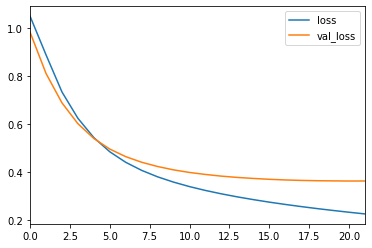

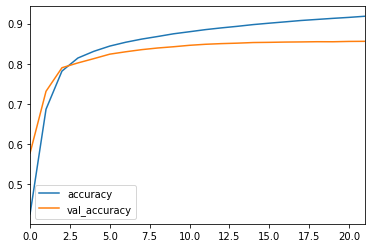

In [24]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [25]:
def build_rnn_model(embed_dim, units):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True),
        GRU(units),
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 8s 107us/sample - loss: 0.7690 - accuracy: 0.6018 - val_loss: 0.5456 - val_accuracy: 0.7404
Epoch 2/100
76962/76962 [==============================] - 6s 73us/sample - loss: 0.3881 - accuracy: 0.8417 - val_loss: 0.3789 - val_accuracy: 0.8481
Epoch 3/100
76962/76962 [==============================] - 6s 73us/sample - loss: 0.2594 - accuracy: 0.9014 - val_loss: 0.3761 - val_accuracy: 0.8543
Epoch 4/100
76962/76962 [==============================] - 5s 70us/sample - loss: 0.2011 - accuracy: 0.9267 - val_loss: 0.3946 - val_accuracy: 0.8507
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 10)            472720    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344    

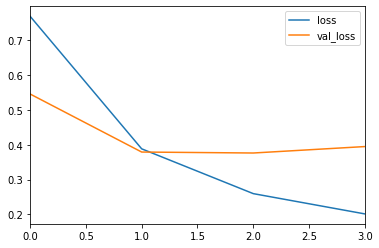

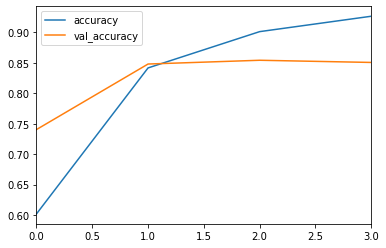

In [26]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'rnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 0

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

rnn_model.summary()

## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [27]:
def build_cnn_model(embed_dim, filters, ksize, strides):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True),
        Conv1D(
            filters=filters,
            kernel_size=ksize,
            strides=strides,
            activation='relu',
        ),
        Flatten(),
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 2s 23us/sample - loss: 0.6698 - accuracy: 0.6848 - val_loss: 0.4312 - val_accuracy: 0.8266
Epoch 2/100
76962/76962 [==============================] - 1s 18us/sample - loss: 0.3334 - accuracy: 0.8662 - val_loss: 0.3726 - val_accuracy: 0.8522
Epoch 3/100
76962/76962 [==============================] - 1s 18us/sample - loss: 0.2436 - accuracy: 0.9056 - val_loss: 0.3790 - val_accuracy: 0.8528
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 5)             236360    
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 200)           3200      
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
________________

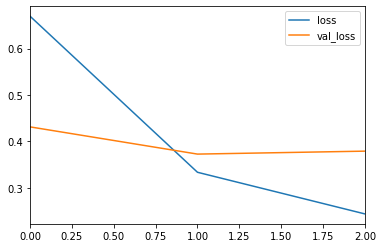

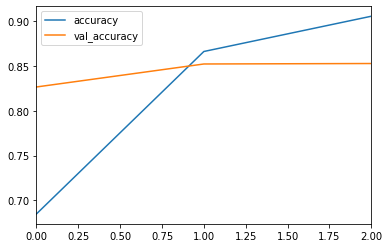

In [28]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 0


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

### Comparing the models

At last, let's compare all the models we have trained at once using TensorBoard in order
to choose the one that overfits the less for the same performance level.

Running the following command will launch TensorBoard on port 6006. This will
block the notebook execution, so you'll have to interrupt that cell first before
you can run other cells.


In [ ]:
!tensorboard --logdir $LOGDIR --port 6006

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License